In [1]:
from pathlib import Path

import pandas as pd
import pulp
import matplotlib.pyplot as plt

In [2]:
# Set path
students_path = Path("../3.school/students.csv")
student_pair_path = Path("../3.school/student_pairs.csv")
class_name_path = Path("./class_name.csv")

In [3]:
# load data
students_df = pd.read_csv(students_path)
student_pair_df = pd.read_csv(student_pair_path)
class_name_df = pd.read_csv(class_name_path)
print(students_df.shape)

(318, 5)


In [4]:
class_name_df

,class_name
0,A
1,B
2,C
3,D
4,E
5,F
6,G
7,H


In [5]:
students_df.head()

,student_id,gender,leader_flag,support_flag,score
0,1,0,0,0,335
1,2,1,0,0,379
2,3,0,0,0,350
3,4,0,0,0,301
4,5,1,0,0,317


In [6]:
student_pair_df.head()

,student_id1,student_id2
0,118,189
1,72,50
2,314,233


# データの中身の確認

array([[<AxesSubplot:title={'center':'score'}>]], dtype=object)

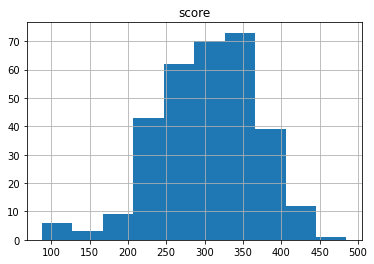

In [7]:
students_df.hist("score")

In [8]:
# student id の重複を確認する
set(range(1, 319)) == set(students_df["student_id"].tolist())

True

In [9]:
students_df["gender"].value_counts()

0    160
1    158
Name: gender, dtype: int64

In [10]:
students_df["leader_flag"].value_counts()

0    301
1     17
Name: leader_flag, dtype: int64

In [11]:
students_df["support_flag"].value_counts()

0    314
1      4
Name: support_flag, dtype: int64

### リスト，定数，変数，制約式，目的関数を順に定めて，プログラムする．

In [12]:
prob = pulp.LpProblem("ClassificationAlgoritm", sense=pulp.LpMaximize)

# リストの定義
S = students_df["student_id"].tolist()
C = class_name_df["class_name"].tolist()

# 定数の定義
# 生徒の点数
# 平均点

# 変数の定義
SC = [(s,c) for s in S for c in C]
x = pulp.LpVariable.dicts("SC", SC, cat=pulp.LpBinary)

In [13]:
# 制約式の定義
# (1) 一人の生徒に一つのクラスを割り当てる．
for s in S:
    prob += pulp.lpSum([x[s, c] for c in C]) == 1

In [14]:
# (2) 各クラスの生徒の人数は39人以上，40人以下
for c in C:
    prob += pulp.lpSum([x[s, c] for s in S]) >= 39
    prob += pulp.lpSum([x[s, c] for s in S]) <= 40

In [15]:
# (3) 各クラスの男子生徒、女子生徒の人数は20人以下とする。
# 男子生徒のリスト，女子生徒のリスト
S_male = [row.student_id for row in students_df.itertuples() if row.gender==1]
S_female = [row.student_id for row in students_df.itertuples() if row.gender==0]

for c in C:
    prob += pulp.lpSum([x[s, c] for s in S_male]) <=20
    prob += pulp.lpSum([x[s, c] for s in S_female]) <=20

In [16]:
# (4) 各クラスの学力試験の平均点は学年平均点±10点とする。
score_mean = students_df["score"].mean()
scores = {row.student_id:row.score for row in students_df.itertuples()}


for c in C:
    prob += (score_mean - 10) * pulp.lpSum([x[s, c] for s in S]) \
            <= pulp.lpSum([x[s, c] * scores[s] for s in S])
    prob += (score_mean + 10) * pulp.lpSum([x[s, c] for s in S]) \
            >= pulp.lpSum([x[s, c] * scores[s] for s in S])

In [17]:
# (5) 各クラスにリーダー気質の生徒を2人以上割り当てる。
leader = {row.student_id:row.leader_flag for row in students_df.itertuples()}

for c in C:
    prob += pulp.lpSum([x[s,c]*leader[s] for s in S]) >= 2

In [18]:
# (6) 特別な支援が必要な生徒は各クラスに1人以下とする。
support = {row.student_id:row.support_flag for row in students_df.itertuples()}

for c in C:
    prob += pulp.lpSum([x[s, c]*support[s] for s in S]) <= 1

In [19]:
# (7) 特定ペアの生徒は同一クラスに割り当てない。
# 特定のペアのxの和が1以下であれば良い．
SS = [(row.student_id1, row.student_id2) for row in student_pair_df.itertuples()]

for s1, s2 in SS:
    for c in C:
        prob += x[s1, c] + x[s2, c] <= 1

In [20]:
print(prob)

ClassificationAlgoritm:
MAXIMIZE
None
SUBJECT TO
_C1: SC_(1,_'A') + SC_(1,_'B') + SC_(1,_'C') + SC_(1,_'D') + SC_(1,_'E')
 + SC_(1,_'F') + SC_(1,_'G') + SC_(1,_'H') = 1

_C2: SC_(2,_'A') + SC_(2,_'B') + SC_(2,_'C') + SC_(2,_'D') + SC_(2,_'E')
 + SC_(2,_'F') + SC_(2,_'G') + SC_(2,_'H') = 1

_C3: SC_(3,_'A') + SC_(3,_'B') + SC_(3,_'C') + SC_(3,_'D') + SC_(3,_'E')
 + SC_(3,_'F') + SC_(3,_'G') + SC_(3,_'H') = 1

_C4: SC_(4,_'A') + SC_(4,_'B') + SC_(4,_'C') + SC_(4,_'D') + SC_(4,_'E')
 + SC_(4,_'F') + SC_(4,_'G') + SC_(4,_'H') = 1

_C5: SC_(5,_'A') + SC_(5,_'B') + SC_(5,_'C') + SC_(5,_'D') + SC_(5,_'E')
 + SC_(5,_'F') + SC_(5,_'G') + SC_(5,_'H') = 1

_C6: SC_(6,_'A') + SC_(6,_'B') + SC_(6,_'C') + SC_(6,_'D') + SC_(6,_'E')
 + SC_(6,_'F') + SC_(6,_'G') + SC_(6,_'H') = 1

_C7: SC_(7,_'A') + SC_(7,_'B') + SC_(7,_'C') + SC_(7,_'D') + SC_(7,_'E')
 + SC_(7,_'F') + SC_(7,_'G') + SC_(7,_'H') = 1

_C8: SC_(8,_'A') + SC_(8,_'B') + SC_(8,_'C') + SC_(8,_'D') + SC_(8,_'E')
 + SC_(8,_'F') + SC_(8,_'G') + 

# 目的関数なし

In [21]:
status = prob.solve()
print("--------------------------------")
print(status)
print(pulp.LpStatus[status])

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/yusuke/Documents/PyOptBook/env/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/j9/hc7q_ty53kb29vw6s6nxzdlh0000gn/T/f4ca970386bf4feca5fba03bfd8275af-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/j9/hc7q_ty53kb29vw6s6nxzdlh0000gn/T/f4ca970386bf4feca5fba03bfd8275af-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 411 COLUMNS
At line 20981 RHS
At line 21388 BOUNDS
At line 23934 ENDATA
Problem MODEL has 406 rows, 2545 columns and 15480 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 0 - 0.06 seconds
Cgl0005I 318 SOS with 2544 members
Cgl0004I processed model has 398 rows, 2544 columns (2544 integer (2544 of which binary)) and 12936 elements
Cbc0038I Initial state - 38 integers unsatisfied sum - 10.8844
Cbc0038I Solution found 

In [22]:
C2Ss = {}
for c in C:
    C2Ss[c] = [s for s in S if x[s,c].value()==1]
    
for c in C:
    _s = C2Ss[c]
    print("Classname : ", c)
    print("Num : ", len(_s))
    print("Num. leader : ", sum([leader[s] for s in _s]))
    print("Num. support : ", sum([ support[s] for s in _s]))
    print("Score.avg : ", sum([scores[s] for s in _s])/len(_s))
    print("diff Score.avg : ", score_mean - sum([scores[s] for s in _s])/len(_s))
    # print("Student : ", _s)
    print()

Classname :  A
Num :  40
Num. leader :  2
Num. support :  1
Score.avg :  312.175
diff Score.avg :  -8.530345911949723

Classname :  B
Num :  39
Num. leader :  2
Num. support :  1
Score.avg :  312.1025641025641
diff Score.avg :  -8.4579100145138

Classname :  C
Num :  40
Num. leader :  2
Num. support :  0
Score.avg :  311.075
diff Score.avg :  -7.430345911949701

Classname :  D
Num :  40
Num. leader :  2
Num. support :  0
Score.avg :  298.275
diff Score.avg :  5.369654088050311

Classname :  E
Num :  40
Num. leader :  3
Num. support :  1
Score.avg :  299.95
diff Score.avg :  3.6946540880502994

Classname :  F
Num :  40
Num. leader :  2
Num. support :  0
Score.avg :  298.2
diff Score.avg :  5.444654088050299

Classname :  G
Num :  39
Num. leader :  2
Num. support :  1
Score.avg :  303.87179487179486
diff Score.avg :  -0.22714078374457358

Classname :  H
Num :  40
Num. leader :  2
Num. support :  0
Score.avg :  293.725
diff Score.avg :  9.919654088050265



# 検証

In [23]:
for s in S:
    assigned_class = [x[s,c].value() for c in C if x[s,c].value()==1]
    
    if len(assigned_class) != 1:
        print("Error")


In [24]:
result_df = students_df.copy()
S2C = {s:c for s in S for c in C if x[s,c].value()==1}
result_df['assigned_class'] = result_df["student_id"].map(S2C)

In [25]:
result_df

,student_id,gender,leader_flag,support_flag,score,assigned_class
0,1,0,0,0,335,H
1,2,1,0,0,379,C
2,3,0,0,0,350,D
3,4,0,0,0,301,E
4,5,1,0,0,317,G
...,...,...,...,...,...,...
313,314,0,0,0,244,B
314,315,1,0,0,309,D
315,316,0,0,0,239,C
316,317,1,0,0,356,D


In [26]:
# Check (2)
result_df.groupby("assigned_class")["student_id"].count()

assigned_class
A    40
B    39
C    40
D    40
E    40
F    40
G    39
H    40
Name: student_id, dtype: int64

In [27]:
# Check (3) 各クラスの男子生徒、女子生徒の人数は20人以下とする。
result_df.groupby(["assigned_class", "gender"])["student_id"].count()

assigned_class  gender
A               0         20
                1         20
B               0         20
                1         19
C               0         20
                1         20
D               0         20
                1         20
E               0         20
                1         20
F               0         20
                1         20
G               0         20
                1         19
H               0         20
                1         20
Name: student_id, dtype: int64

In [28]:
# Check (4) 各クラスの学力試験の平均点は学年平均点±10点とする。
result_df.groupby(["assigned_class"])["score"].mean() - score_mean

assigned_class
A    8.530346
B    8.457910
C    7.430346
D   -5.369654
E   -3.694654
F   -5.444654
G    0.227141
H   -9.919654
Name: score, dtype: float64

In [29]:
# Check (5)各クラスにリーダー気質の生徒を2人以上割り当てる。
result_df.groupby(["assigned_class"])["leader_flag"].sum()

assigned_class
A    2
B    2
C    2
D    2
E    3
F    2
G    2
H    2
Name: leader_flag, dtype: int64

In [30]:
# Check (6) 
result_df.groupby(["assigned_class"])["support_flag"].sum()

assigned_class
A    1
B    1
C    0
D    0
E    1
F    0
G    1
H    0
Name: support_flag, dtype: int64

In [31]:
# Check (7)
for row in student_pair_df.itertuples():
    s1, s2 = row.student_id1, row.student_id2
    
    print(S2C[s1], S2C[s2])

E G
F B
B D


# p.75

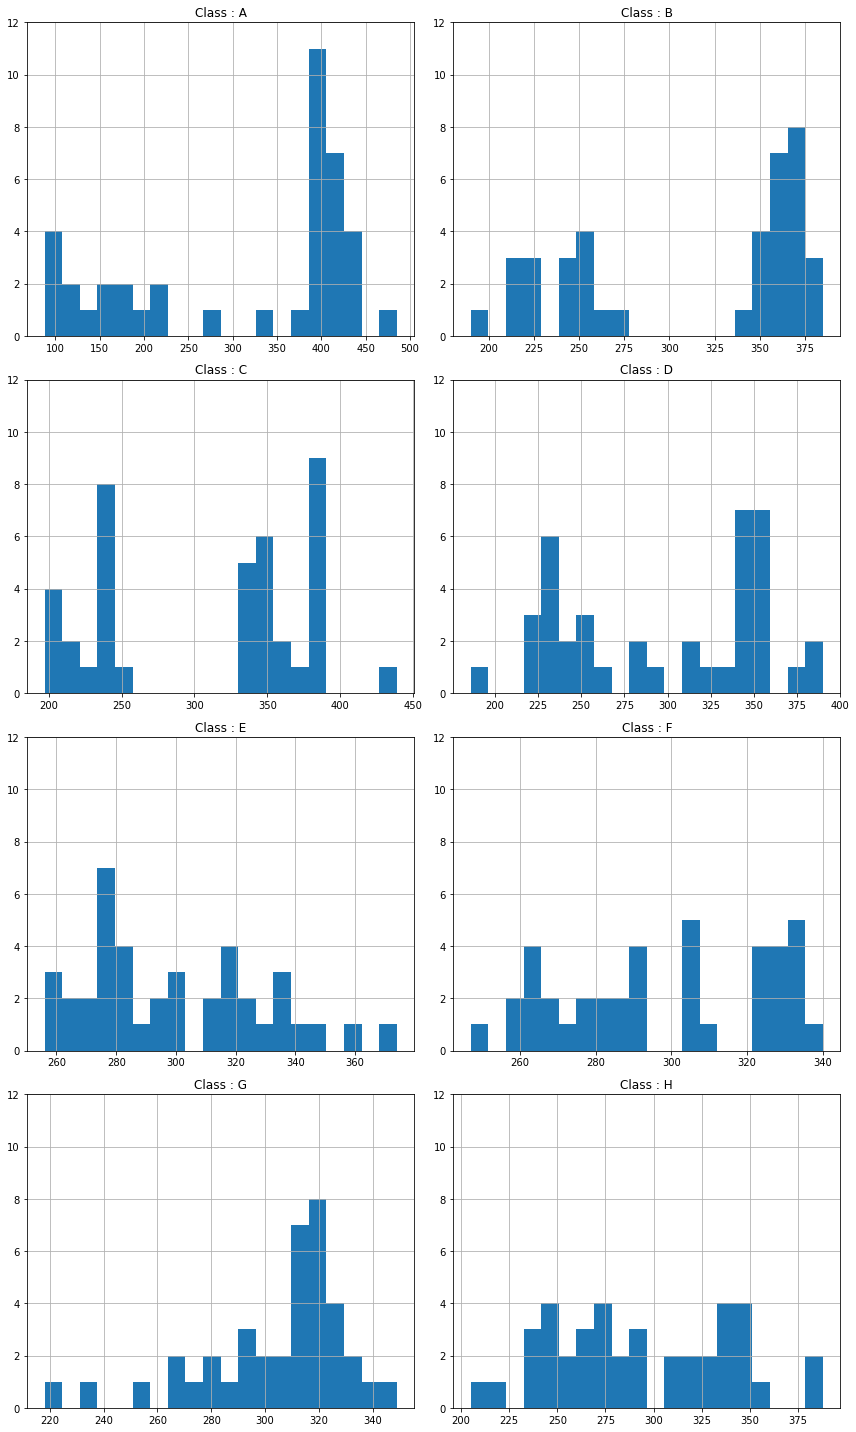

In [32]:
# check score distribution
fig, axes = plt.subplots(4, 2, figsize=(12, 20))

for i, c in enumerate(C):
    cls_df = result_df.loc[result_df["assigned_class"]==c]
    
    row = int(i / 2)
    col = int(i % 2)

    cls_df["score"].hist(bins=20, ax=axes[row, col])
    axes[row, col].set_title(f"Class : {c}")
    axes[row, col].set_ylim(0, 12)
plt.tight_layout()
plt.show()

## 分布が均等になるように初期条件を与えて，その初期条件との差が小さくなるように目的関数を設定する．

In [33]:
students_df["score_rank"] = students_df["score"].rank(ascending=False, method="first")

class_dict = {i:c for i, c in enumerate(C)}
students_df["init_assigned_class"] = students_df["score_rank"].map(lambda x : class_dict[x%8])


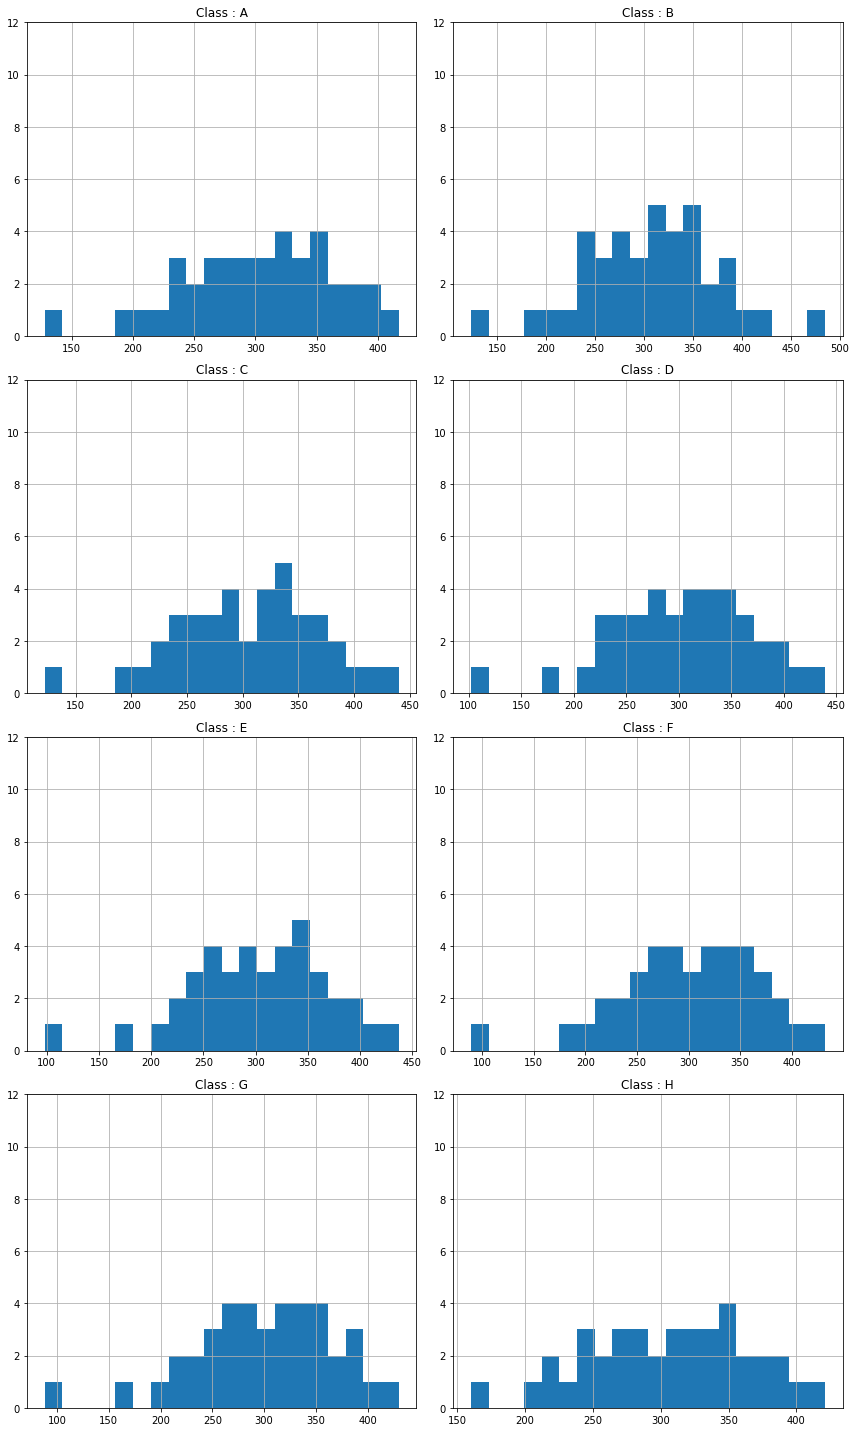

In [34]:
# check score distribution
fig, axes = plt.subplots(4, 2, figsize=(12, 20))

for i, c in enumerate(C):
    cls_df = students_df.loc[students_df["init_assigned_class"]==c]
    
    row = int(i / 2)
    col = int(i % 2)

    cls_df["score"].hist(bins=20, ax=axes[row, col])
    axes[row, col].set_title(f"Class : {c}")
    axes[row, col].set_ylim(0, 12)
plt.tight_layout()
plt.show()

In [35]:
# init_flag
init_flag = {(s,c):0 for s in S for c in C}

for row in students_df.itertuples():
    init_flag[(row.student_id, row.init_assigned_class)] = 1

In [36]:
# reset problem

prob = pulp.LpProblem("ClassificationAlgoritm", sense=pulp.LpMaximize)

# リストの定義
S = students_df["student_id"].tolist()
C = class_name_df["class_name"].tolist()

# 定数の定義
# 生徒の点数
# 平均点

# 変数の定義
SC = [(s,c) for s in S for c in C]
x = pulp.LpVariable.dicts("SC", SC, cat=pulp.LpBinary)
# 制約式の定義
# (1) 一人の生徒に一つのクラスを割り当てる．
for s in S:
    prob += pulp.lpSum([x[s, c] for c in C]) == 1
# (2) 各クラスの生徒の人数は39人以上，40人以下
for c in C:
    prob += pulp.lpSum([x[s, c] for s in S]) >= 39
    prob += pulp.lpSum([x[s, c] for s in S]) <= 40
# (3) 各クラスの男子生徒、女子生徒の人数は20人以下とする。
# 男子生徒のリスト，女子生徒のリスト
S_male = [row.student_id for row in students_df.itertuples() if row.gender==1]
S_female = [row.student_id for row in students_df.itertuples() if row.gender==0]

for c in C:
    prob += pulp.lpSum([x[s, c] for s in S_male]) <=20
    prob += pulp.lpSum([x[s, c] for s in S_female]) <=20
# (4) 各クラスの学力試験の平均点は学年平均点±10点とする。
score_mean = students_df["score"].mean()
scores = {row.student_id:row.score for row in students_df.itertuples()}


for c in C:
    prob += (score_mean - 10) * pulp.lpSum([x[s, c] for s in S]) \
            <= pulp.lpSum([x[s, c] * scores[s] for s in S])
    prob += (score_mean + 10) * pulp.lpSum([x[s, c] for s in S]) \
            >= pulp.lpSum([x[s, c] * scores[s] for s in S])
# (5) 各クラスにリーダー気質の生徒を2人以上割り当てる。
leader = {row.student_id:row.leader_flag for row in students_df.itertuples()}

for c in C:
    prob += pulp.lpSum([x[s,c]*leader[s] for s in S]) >= 2
# (6) 特別な支援が必要な生徒は各クラスに1人以下とする。
support = {row.student_id:row.support_flag for row in students_df.itertuples()}

for c in C:
    prob += pulp.lpSum([x[s, c]*support[s] for s in S]) <= 1
# (7) 特定ペアの生徒は同一クラスに割り当てない。
# 特定のペアのxの和が1以下であれば良い．
SS = [(row.student_id1, row.student_id2) for row in student_pair_df.itertuples()]

for s1, s2 in SS:
    for c in C:
        prob += x[s1, c] + x[s2, c] <= 1

# set purpose function
prob += pulp.lpSum([x[s,c]*init_flag[s,c] for s,c in SC])

status = prob.solve()
print("--------------------------------")
print(status)
print(pulp.LpStatus[status])

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/yusuke/Documents/PyOptBook/env/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/j9/hc7q_ty53kb29vw6s6nxzdlh0000gn/T/c72cb6f12b4f4691a77a3bdc1440954b-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/j9/hc7q_ty53kb29vw6s6nxzdlh0000gn/T/c72cb6f12b4f4691a77a3bdc1440954b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 411 COLUMNS
At line 21298 RHS
At line 21705 BOUNDS
At line 24250 ENDATA
Problem MODEL has 406 rows, 2544 columns and 15480 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 298 - 0.00 seconds
Cgl0005I 318 SOS with 2544 members
Cgl0004I processed model has 398 rows, 2544 columns (2544 integer (2544 of which binary)) and 12936 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 0 integers u

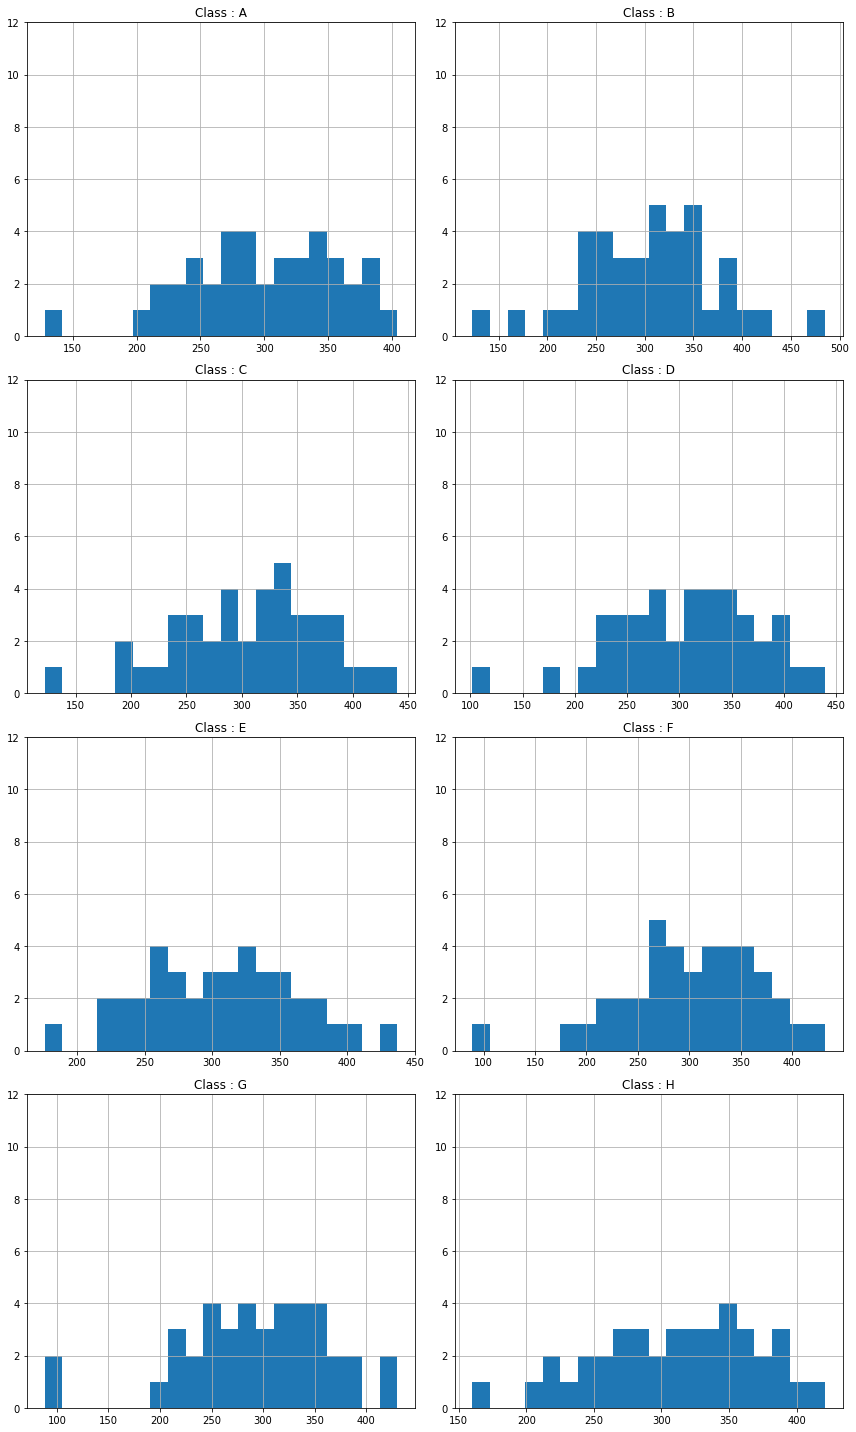

In [37]:
result_df = students_df.copy()
S2C = {s:c for s in S for c in C if x[s,c].value()==1}
result_df['assigned_class'] = result_df["student_id"].map(S2C)
# check score distribution
fig, axes = plt.subplots(4, 2, figsize=(12, 20))

for i, c in enumerate(C):
    cls_df = result_df.loc[result_df["assigned_class"]==c]
    
    row = int(i / 2)
    col = int(i % 2)

    cls_df["score"].hist(bins=20, ax=axes[row, col])
    axes[row, col].set_title(f"Class : {c}")
    axes[row, col].set_ylim(0, 12)
plt.tight_layout()
plt.show()

In [38]:
# reset problem

prob = pulp.LpProblem("ClassificationAlgoritm", sense=pulp.LpMaximize)

# リストの定義
S = students_df["student_id"].tolist()
C = class_name_df["class_name"].tolist()

# 定数の定義
# 生徒の点数
# 平均点

# 変数の定義
SC = [(s,c) for s in S for c in C]
x = pulp.LpVariable.dicts("SC", SC, cat=pulp.LpBinary)
# 制約式の定義
# (1) 一人の生徒に一つのクラスを割り当てる．
for s in S:
    prob += pulp.lpSum([x[s, c] for c in C]) == 1
# (2) 各クラスの生徒の人数は39人以上，40人以下
for c in C:
    prob += pulp.lpSum([x[s, c] for s in S]) >= 39
    prob += pulp.lpSum([x[s, c] for s in S]) <= 40
# (3) 各クラスの男子生徒、女子生徒の人数は20人以下とする。
# 男子生徒のリスト，女子生徒のリスト
S_male = [row.student_id for row in students_df.itertuples() if row.gender==1]
S_female = [row.student_id for row in students_df.itertuples() if row.gender==0]

for c in C:
    prob += pulp.lpSum([x[s, c] for s in S_male]) <=20
    prob += pulp.lpSum([x[s, c] for s in S_female]) <=20
# (4) 各クラスの学力試験の平均点は学年平均点±10点とする。
score_mean = students_df["score"].mean()
scores = {row.student_id:row.score for row in students_df.itertuples()}


for c in C:
    prob += (score_mean - 10) * pulp.lpSum([x[s, c] for s in S]) \
            <= pulp.lpSum([x[s, c] * scores[s] for s in S])
    prob += (score_mean + 10) * pulp.lpSum([x[s, c] for s in S]) \
            >= pulp.lpSum([x[s, c] * scores[s] for s in S])
# (5) 各クラスにリーダー気質の生徒を2人以上割り当てる。
leader = {row.student_id:row.leader_flag for row in students_df.itertuples()}

for c in C:
    prob += pulp.lpSum([x[s,c]*leader[s] for s in S]) >= 2
# (6) 特別な支援が必要な生徒は各クラスに1人以下とする。
support = {row.student_id:row.support_flag for row in students_df.itertuples()}

for c in C:
    prob += pulp.lpSum([x[s, c]*support[s] for s in S]) <= 1
# (7) 特定ペアの生徒は同一クラスに割り当てない。
# 特定のペアのxの和が1以下であれば良い．
SS = [(row.student_id1, row.student_id2) for row in student_pair_df.itertuples()]

for s1, s2 in SS:
    for c in C:
        prob += x[s1, c] + x[s2, c] <= 1
        
# set purpose function
# prob += pulp.lpSum([x[s,c]*init_flag[s,c] for s,c in SC])

init_assigned_class = [(s, c) for s, c in zip(students_df["student_id"].values, students_df["init_assigned_class"].values)]
prob += pulp.lpSum([x[s,c] for s,c in init_assigned_class])

status = prob.solve()
print("--------------------------------")
print(status)
print(pulp.LpStatus[status])

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/yusuke/Documents/PyOptBook/env/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/j9/hc7q_ty53kb29vw6s6nxzdlh0000gn/T/8dba114cac514d3a9195664e21dbf0e4-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/j9/hc7q_ty53kb29vw6s6nxzdlh0000gn/T/8dba114cac514d3a9195664e21dbf0e4-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 411 COLUMNS
At line 21298 RHS
At line 21705 BOUNDS
At line 24250 ENDATA
Problem MODEL has 406 rows, 2544 columns and 15480 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 298 - 0.00 seconds
Cgl0005I 318 SOS with 2544 members
Cgl0004I processed model has 398 rows, 2544 columns (2544 integer (2544 of which binary)) and 12936 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 0 integers u

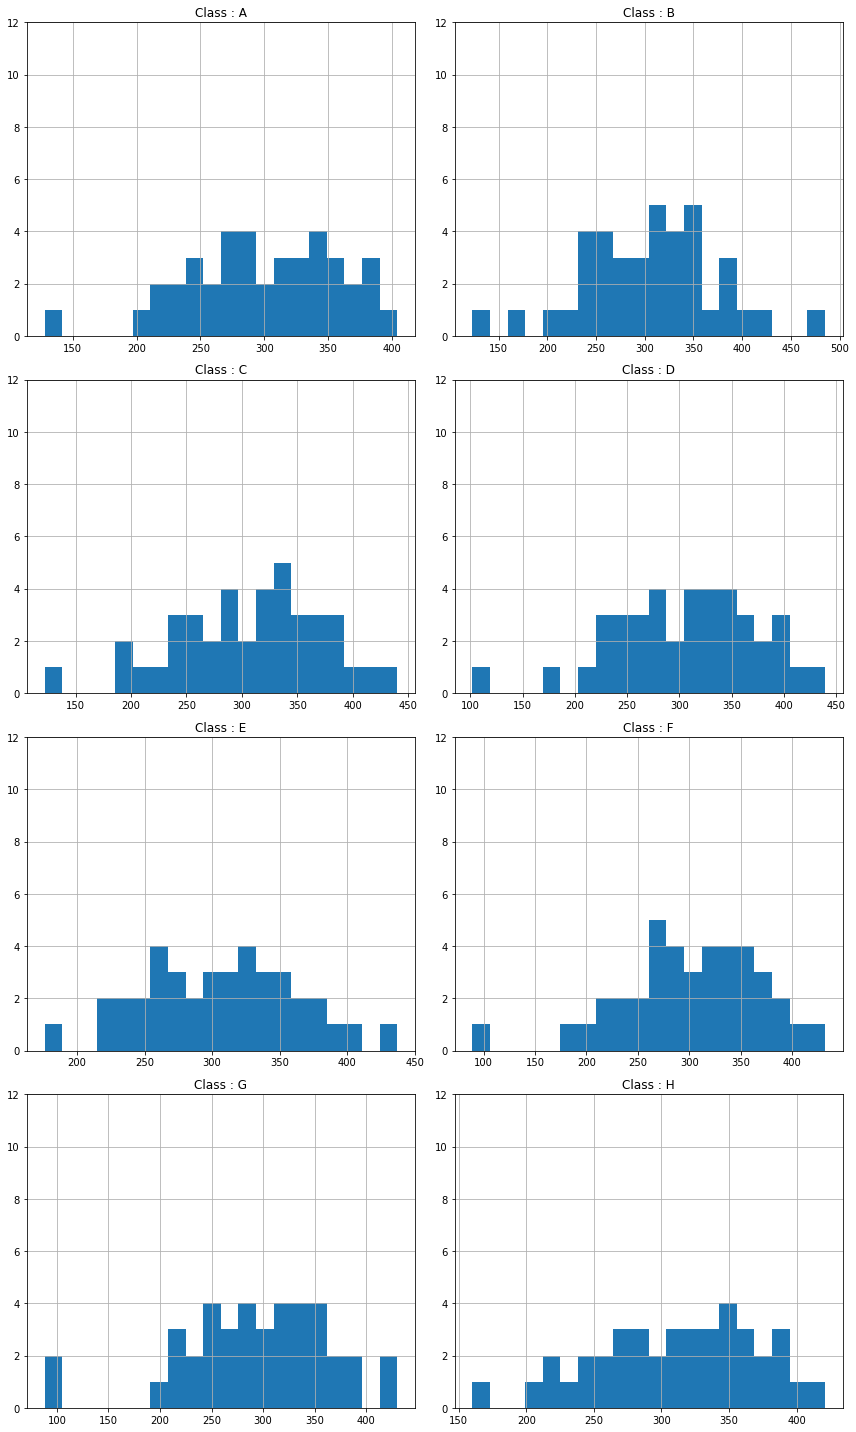

In [39]:
result_df = students_df.copy()
S2C = {s:c for s in S for c in C if x[s,c].value()==1}
result_df['assigned_class'] = result_df["student_id"].map(S2C)
# check score distribution
fig, axes = plt.subplots(4, 2, figsize=(12, 20))

for i, c in enumerate(C):
    cls_df = result_df.loc[result_df["assigned_class"]==c]
    
    row = int(i / 2)
    col = int(i % 2)

    cls_df["score"].hist(bins=20, ax=axes[row, col])
    axes[row, col].set_title(f"Class : {c}")
    axes[row, col].set_ylim(0, 12)
plt.tight_layout()
plt.show()

# Done! Chapter 3